In [382]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat, umath, unumpy
from copy import deepcopy
from math import log10, floor
from decimal import Decimal
#import scipy.optimize as opt

In [383]:
# Settings and Logistics
# Plotting Settings
plt.style.use("default")

    # # remove interactive mode
# plt.ioff()

    # # disable images from automatically showing up
# use("Agg")

# Exporting Saved Images
def export_plot(plot, filename, savelocation="../exports/", _quality=95, _dpi=100, _optimize=True):
    """Saves a plot to the specified location."""
    plot.savefig(str(savelocation + filename), quality=_quality, dpi=_dpi, optimize=_optimize)

In [384]:
# Constants
G = ufloat(9.81, 0.03)  # the gravitational acceleration measured at UofT MP: https://faraday.physics.utoronto.ca/PVB/Harrison/ErrorAnalysis/Introduction.html

UNCERTAINTY_RULER = 0.05  # cm
UNCERTAINTY_CURRENT = 0.01 # 10^-1 A
UNCERTAINTY_VOLTAGE = 0.1 # Volts

# Convert to SI/Update
UNCERTAINTY_RULER = UNCERTAINTY_RULER/100  # m
UNCERTAINTY_CURRENT = UNCERTAINTY_CURRENT/10  # A

MU_KNOT = 4*np.pi*pow(10, -7)  # Kg*m/(s^2 A^2)
COIL_TURNS = 16  # no units
COIL_RADIUS = ufloat(16/100, UNCERTAINTY_RULER)  # m

INDEX_VOLTAGE = 0
INDEX_CURRENT = 1
INDEX_DIAMETER = 2

K = (1/sqrt(2)) * pow(4/5, 3/2) * MU_KNOT * COIL_TURNS / COIL_RADIUS

In [385]:
# Raw Data [Voltage (V), Current (A), Diameter (m)]
data1 = [[317.6, 19.97, 7.00], [296.5, 19.97, 6.50], [278.0, 19.97, 6.00]]

data2 = [[278.0, 20.43, 6.00], [213.9, 9.08, 12.30], [213.9, 10.59, 10.70], [195.1, 10.62, 9.60], [195.1, 8.78, 12.1], [158.2, 8.78, 9.60], [315.9, 10.71, 12.8], [301.8, 11.70, 11.6], [208.8, 10.89, 10.5], [185.1, 10.26, 9.50], [165.0, 7.41, 12.60], [208.4, 7.45, 13.1], [270.9, 18.57, 6.80], [270.9, 15.19, 8.40], [315.3, 21.00, 6.10], [260.9, 12.49, 9.40]]

data = deepcopy(data1) + deepcopy(data2)
# update units to be volts, amprees, and meter
for i in range(len(data)):  # n samples
    data[i][INDEX_VOLTAGE] = convert_to_ufloat(data[i][INDEX_VOLTAGE], UNCERTAINTY_VOLTAGE)  # V
    data[i][INDEX_CURRENT] = convert_to_ufloat(data[i][INDEX_CURRENT]/10, UNCERTAINTY_CURRENT)  # A
    data[i][INDEX_DIAMETER] = convert_to_ufloat(data[i][INDEX_DIAMETER]/100, UNCERTAINTY_RULER)  # m

data = sorted(data, key=lambda s: s[INDEX_VOLTAGE])

print(*data, sep='\n')


[158.2+/-0.05, 0.8779999999999999+/-0.0005, 0.096+/-0.0005]
[165.0+/-0.05, 0.741+/-0.0005, 0.126+/-0.0005]
[185.1+/-0.05, 1.026+/-0.0005, 0.095+/-0.0005]
[195.1+/-0.05, 1.0619999999999998+/-0.0005, 0.096+/-0.0005]
[195.1+/-0.05, 0.8779999999999999+/-0.0005, 0.121+/-0.0005]
[208.4+/-0.05, 0.745+/-0.0005, 0.131+/-0.0005]
[208.8+/-0.05, 1.089+/-0.0005, 0.105+/-0.0005]
[213.9+/-0.05, 0.908+/-0.0005, 0.12300000000000001+/-0.0005]
[213.9+/-0.05, 1.059+/-0.0005, 0.107+/-0.0005]
[260.9+/-0.05, 1.249+/-0.0005, 0.094+/-0.0005]
[270.9+/-0.05, 1.857+/-0.0005, 0.068+/-0.0005]
[270.9+/-0.05, 1.519+/-0.0005, 0.084+/-0.0005]
[278.0+/-0.05, 1.9969999999999999+/-0.0005, 0.06+/-0.0005]
[278.0+/-0.05, 2.043+/-0.0005, 0.06+/-0.0005]
[296.5+/-0.05, 1.9969999999999999+/-0.0005, 0.065+/-0.0005]
[301.8+/-0.05, 1.17+/-0.0005, 0.11599999999999999+/-0.0005]
[315.3+/-0.05, 2.1+/-0.0005, 0.061+/-0.0005]
[315.9+/-0.05, 1.0710000000000002+/-0.0005, 0.128+/-0.0005]
[317.6+/-0.05, 1.9969999999999999+/-0.0005, 0.07+/-0.

In [386]:
# Equations
def mean(array):
    return sum(array)/len(array)

def standard_deviation(array):
    numerator = 0
    arrayMean = mean(array)
    N = len(array)
    for i in range(N):
        numerator += umath.pow((array[i] - arrayMean), 2)
    return umath.pow((numerator/N), 1/2)

def convert_to_ufloat(data, uncert):
    if not isinstance(data, (list, tuple, set)):
        return ufloat(data, uncert)
    return [ufloat(e, uncert) for e in data]

def seperate_ufloat(data):
    if not isinstance(data, (list, tuple, set)):
        return data.nominal_value, data.std_dev
    nominals, devs = [], []
    for e in data:
        nominals.append(e.nominal_value)
        devs.append(e.std_dev)
    return nominals, devs

def chi_squared(dataX, dataY, f):
    chi2 = 0
    for i in range(len(dataX)):
        collected = dataY[i]
        actual = f(dataX[i])
        chi2 = (umath.pow(actual - collected, 2))/actual
    return chi2

def coeff_of_determination(dataX, dataY, func):
    N = len(dataX)
    yBar = mean(dataY)
    SS_tot = [umath.pow((e - yBar), 2) for e in dataY]
    SS_reg = [umath.pow((func(dataX[i]) - yBar), 2) for i in range(N)]
    SS_res = [umath.pow((dataY[i] - func(dataX[i])), 2) for i in range(N)]
    return 1 - sum(SS_res)/sum(SS_tot)

def round_sig(x, sig=1):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def equation_5(current):
    """Returns B_c value units of kg/(s^2 * A) = Telse [T]"""
    result = pow(4/5, 3/2) * MU_KNOT * COIL_TURNS * current / COIL_RADIUS
    return result

def calculate_I0(b_e):
    return b_e/K

def calculate_em(v, r, i, i0):
    numerator = v
    denominator = umath.pow(K*r*(i - i0), 2)
    return numerator/denominator

B_e is -6.80E-06+/-2.69E-05 [T]


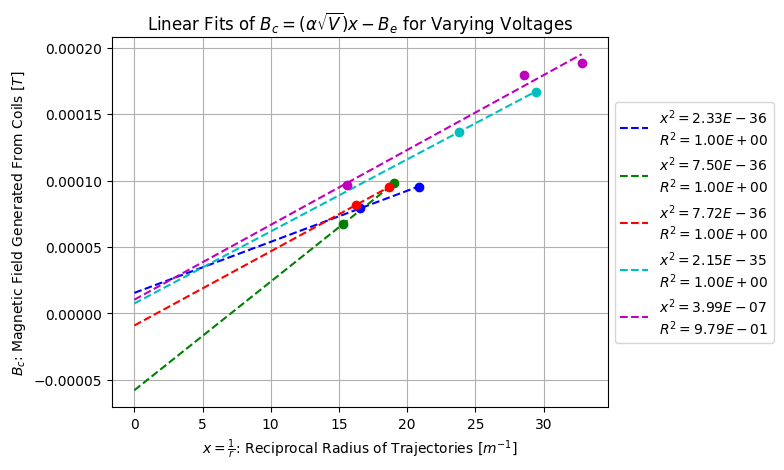

In [387]:
# Q3: Calculate B_e magnetic field

# Paritions of voltage to plot
    # indices of partitions of data
paritions = [[3, 4], [5, 6], [7, 8], [10, 11], [16, 17, 18]]
colours = ["b", "g", "r", "c", "m", "k"]
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_title("Linear Fits of $B_c = (\\alpha \sqrt{V})x -B_e$ for Varying Voltages")
ax.set_xlabel("$x=\\frac{1}{r}$: Reciprocal Radius of Trajectories [$m^{-1}$]")
ax.set_ylabel("$B_c$: Magnetic Field Generated From Coils $[T]$")


# fit the partitions
intercepts = []
base_error = 0.0005
legends = []
for i in range(len(paritions)):
    partsX, partsY = [], []
    for j in paritions[i]:
        current = data[j][INDEX_CURRENT]
        B_c = equation_5(current)
        partsX.append(umath.pow(data[j][INDEX_DIAMETER]/2, -1))
        partsY.append(B_c)
    partsX_nom, partsX_uncert = seperate_ufloat(partsX)
    partsY_nom, partsY_uncert = seperate_ufloat(partsY)
    ax.errorbar(partsX_nom, partsY_nom, partsY_uncert, partsX_uncert, colours[i] + "o")
    if len(paritions[i]) <= 2:
        coeffs = np.polyfit(partsX_nom, partsY_nom, deg=1, full=False, cov=False)
        intercepts.append(convert_to_ufloat(coeffs[1], base_error))
    else:
        coeffs, cov = np.polyfit(partsX_nom, partsY_nom, deg=1, full=False, cov=True)
        slope_uncert = np.sqrt(cov[0,0])  # m^(-1)
        intercept_uncert = np.sqrt(cov[1, 1])  # T
        intercepts.append(convert_to_ufloat(coeffs[1], intercept_uncert))
    # fit the line
    p = np.poly1d(coeffs)
    minX = min(partsX_nom)
    maxX = max(partsX_nom)
    points = [0, maxX]
    ax.plot(points, p(points), colours[i] + "--")

    x2 = chi_squared(partsX_nom, partsY_nom, p)
    r2 = coeff_of_determination(partsX_nom, partsY_nom, p)
    legends.append("$x^2={}$\n$R^2={}$".format('%.2E' % Decimal(x2), '%.2E' % Decimal(r2)))

ax.legend(legends, loc="center left", bbox_to_anchor=(1, 0.5))
export_plot(fig, "q3_linear_fits")

intercepts_nom, intercepts_uncert = seperate_ufloat(intercepts)

be_mean = mean(intercepts_nom)
be_std = standard_deviation(intercepts_nom)
print("B_e is {}+/-{} [T]".format('%.2E' % Decimal(be_mean), '%.2E' % Decimal(be_std)))
        


In [389]:
#Q5: Calculate e/m
dataEM = []
for i in range(len(paritions)):
    for j in paritions[i]:
        volt = data[i][INDEX_VOLTAGE]  # v
        current = data[i][INDEX_CURRENT]  # A
        i0 = calculate_I0(intercepts[i])  # b_e /k
        r = data[i][INDEX_DIAMETER]/2  # m
        em_s = calculate_em(volt, r, current, i0)
        dataEM.append([volt, r, current, i0, em_s])
    
justEM = [row[-1] for row in dataEM]
em_nom, em_uncert = seperate_ufloat(justEM)


em_mean = mean(em_nom)/100
em_std = standard_deviation(em_nom)/100
print("e/m is {}+/-{} [C/kg]".format('%.2E' % Decimal(em_mean), '%.2E' % Decimal(em_std)))





e/m is 2.23E+11+/-1.21E+11 [C/kg]
